<a href="https://colab.research.google.com/github/firdyannnn/Deep-Learning-Lanjut/blob/main/Deep_Learning_Lanjut_Pertemuan_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

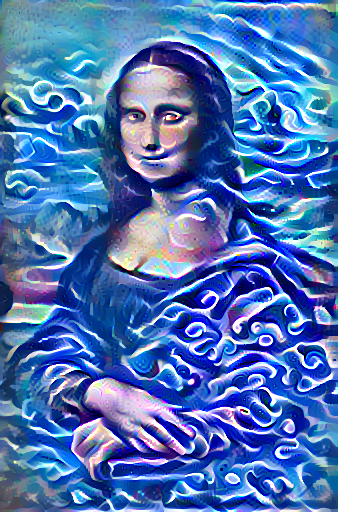

>>> GAMBAR HASIL AKHIR (Neural Style Transfer) <<<

Hasil telah disimpan sebagai 'monalisa_gaya_batik_kuat_nst.png'


In [7]:
import tensorflow as tf
import numpy as np
import time
from PIL import Image
import IPython.display as display
import functools

# Pastikan TensorFlow menggunakan GPU jika tersedia
print("Versi TensorFlow:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU tersedia. Menggunakan GPU.")
else:
    print("GPU tidak tersedia. Menggunakan CPU.")

content_path = 'monalisa.jpg'   # Konten: Monalisa
style_path = 'Batik.jpg'        # Gaya: Batik

# Ukuran gambar yang diinginkan. Dibatasi untuk komputasi yang lebih cepat di Colab.
img_size = 512

def load_img(path_to_img):
    """Memuat dan memproses gambar."""
    # Batasi ukuran gambar
    max_dim = img_size
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # Tambahkan dimensi batch (batch size 1)
    return img

def tensor_to_image(tensor):
    """Konversi tensor hasil kembali ke format gambar untuk penyimpanan/tampilan."""
    # Hapus dimensi batch
    tensor = tf.squeeze(tensor, axis=0)
    # Konversi dari float [0, 1] ke uint8 [0, 255]
    tensor = tensor.numpy()
    tensor = np.clip(tensor * 255, 0, 255).astype('uint8')
    return Image.fromarray(tensor)

def imshow(image, title=None):
    """Menampilkan gambar hasil dalam Colab."""
    # Gunakan utilitas bawaan Colab/IPython untuk tampilan yang lebih baik
    display.display(tensor_to_image(image))
    if title:
        print(title)

# Tampilkan Gambar Konten dan Gaya asli yang akan diproses
content_image = load_img(content_path)
style_image = load_img(style_path)

print("Gambar Konten dan Gaya yang akan digunakan:")
imshow(content_image, 'Gambar Konten (Monalisa)')
imshow(style_image, 'Gambar Gaya (Batik)')

# ----------------------------------------------------------------------
# 3. Model VGG19 untuk Ekstraksi Fitur
# ----------------------------------------------------------------------

# Lapisan yang akan digunakan untuk menghitung Content Loss (mengambil detail struktur)
content_layers = ['block5_conv2']

# Lapisan yang akan digunakan untuk menghitung Style Loss (mengambil tekstur dan warna)
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def vgg_layers(layer_names):
    """Membuat model Keras yang mengembalikan output dari layer-layer yang ditentukan."""
    # Muat model VGG19 yang telah dilatih sebelumnya di ImageNet (tanpa lapisan klasifikasi di atas)
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

# ----------------------------------------------------------------------
# 4. Implementasi Gram Matrix dan Style Loss
# ----------------------------------------------------------------------

def gram_matrix(input_tensor):
    """
    Menghitung Gram Matrix dari peta fitur.
    Gram Matrix mengukur korelasi antara aktivasi fitur di suatu lapisan.
    Ini adalah representasi statistik dari 'gaya' gambar.
    """
    # Operasi einsum untuk produk dot antar fitur: (tinggi * lebar, tinggi * lebar)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    input_shape = tf.shape(input_tensor)
    num_channels = tf.cast(input_shape[3], tf.float32)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    # Normalisasi Gram Matrix untuk ukuran yang adil
    return result / (num_channels * num_locations)


# ----------------------------------------------------------------------
# 5. StyleContentModel: Model End-to-End
# ----------------------------------------------------------------------

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()

        # Inisialisasi VGG19 dan lapisan yang relevan
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)

        # Fungsi pre-processing bawaan VGG19 (menggeser rata-rata piksel ImageNet)
        self.preprocess = tf.keras.applications.vgg19.preprocess_input

    def call(self, inputs):
        """Memproses input dan mengembalikan Style dan Content features."""
        # VGG19 mengharapkan input di rentang [0, 255]
        inputs = inputs * 255.0
        preprocessed_input = self.preprocess(inputs)
        outputs = self.vgg(preprocessed_input)

        # Pisahkan output
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        # Hitung Gram Matrix untuk setiap Style Layer
        style_features = [gram_matrix(style_output) for style_output in style_outputs]

        # Kembalikan sebagai dictionary
        style_dict = {name: value for name, value in zip(self.style_layers, style_features)}
        content_dict = {name: value for name, value in zip(self.content_layers, content_outputs)}

        return {'content': content_dict, 'style': style_dict}


# ----------------------------------------------------------------------
# 6. Definisi Fungsi Loss dan Hyperparameter
# ----------------------------------------------------------------------

extractor = StyleContentModel(style_layers, content_layers)

# Ekstrak target (target Gram Matrix untuk Gaya, target fitur untuk Konten)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar hasil yang akan dioptimalkan. Dimulai dari gambar konten (Monalisa).
image = tf.Variable(content_image)

# Konstanta Loss (dapat disetel untuk hasil yang berbeda)
style_weight=1e2           # <<< PENINGKATAN DRASTIS DI SINI (100.0)
content_weight=1e4
total_variation_weight=50.0  # <<< PENINGKATAN TV LOSS UNTUK KEHALUSAN

# Optimizer: Adam dengan Learning Rate yang cukup besar
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def style_content_loss(outputs):
    """Menghitung total Style dan Content Loss."""
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Content Loss (MSE antara fitur Content)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)

    # Style Loss (MSE antara Gram Matrix)
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    # Total Loss (Style + Content)
    total_loss = content_loss + style_loss
    return total_loss

def total_variation_loss(image):
    """Menghitung Total Variation Loss (TV Loss) untuk menghaluskan output."""
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))


# ----------------------------------------------------------------------
# 7. Fungsi Pelatihan (Gradient Descent)
# ----------------------------------------------------------------------

# Gunakan @tf.function untuk kompilasi grafik TensorFlow, mempercepat pelatihan
@tf.function()
def train_step(image):
    """Satu langkah optimasi menggunakan Gradient Descent."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        # Tambahkan TV Loss untuk regularisasi
        loss += total_variation_loss(image) * total_variation_weight

    # Hitung gradien Loss terhadap Gambar yang sedang dioptimalkan
    grad = tape.gradient(loss, image)
    # Terapkan gradien
    opt.apply_gradients([(grad, image)])

    # Batasi nilai piksel agar tetap berada dalam rentang [0, 1]
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

# ----------------------------------------------------------------------
# 8. Loop Optimasi Utama
# ----------------------------------------------------------------------

# Atur jumlah iterasi untuk hasil yang baik
epochs = 10
steps_per_epoch = 100
total_steps = epochs * steps_per_epoch

print(f"\nMemulai optimasi selama {total_steps} langkah...")
start_time = time.time()
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        if step % 100 == 0:
            display.clear_output(wait=True)
            print(f"Langkah {step}/{total_steps} - Memvisualisasikan hasil...")
            imshow(image, f"Hasil Setelah {step} langkah")

# Akhir pelatihan
end_time = time.time()
print(f"\nOptimasi selesai setelah {int(end_time - start_time)} detik.")

# Tampilkan gambar akhir
display.clear_output(wait=True)
imshow(image, '>>> GAMBAR HASIL AKHIR (Neural Style Transfer) <<<')

# Simpan hasilnya
final_image_pil = tensor_to_image(image)
output_filename = 'monalisa_gaya_batik_kuat_nst.png' # <<< NAMA FILE BARU
final_image_pil.save(output_filename)
print(f"\nHasil telah disimpan sebagai '{output_filename}'")